# Data Load

In [1]:
import pandas as pd
data = pd.read_csv("data_interview_test.csv", delimiter = ':',low_memory=False)
data.head(5)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [2]:
data.describe()

,company_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,27247.797906,0.217901,0.031660,0.021522,0.986455,0.013877,0.024215,0.037893,0.753532,0.001005,0.076533
std,12024.542988,0.384535,0.122611,0.116995,0.115597,0.116987,0.128646,0.190945,0.430972,0.020134,0.265860
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,50000.000000,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000


In [3]:
list(data)

['receipt_id',
 'company_id',
 'matched_transaction_id',
 'feature_transaction_id',
 'DateMappingMatch',
 'AmountMappingMatch',
 'DescriptionMatch',
 'DifferentPredictedTime',
 'TimeMappingMatch',
 'PredictedNameMatch',
 'ShortNameMatch',
 'DifferentPredictedDate',
 'PredictedAmountMatch',
 'PredictedTimeCloseMatch']

In [4]:
# Making Flag
import numpy as np
data['Match_Flag']= np.where(data['matched_transaction_id'] == data['feature_transaction_id'],1,0) 
data['Match_Flag'].value_counts()

0    11177
1      857
Name: Match_Flag, dtype: int64

In [5]:
print("event_rate is:",(data['Match_Flag'].sum()/len(data))*100)

event_rate is: 7.121489114176501


The event rate of 7.12% is very low, therefore there's a huge class imbalance which exists. We will have to apply SMOTE to build a model

In [6]:
#Keeping only the required columns
data_v1=data[[ 'DateMappingMatch',
 'AmountMappingMatch',
 'DescriptionMatch',
 'DifferentPredictedTime',
 'TimeMappingMatch',
 'PredictedNameMatch',
 'ShortNameMatch',
 'DifferentPredictedDate',
 'PredictedAmountMatch',
 'PredictedTimeCloseMatch',
 'Match_Flag']]

# Correlation Check

<Axes: >

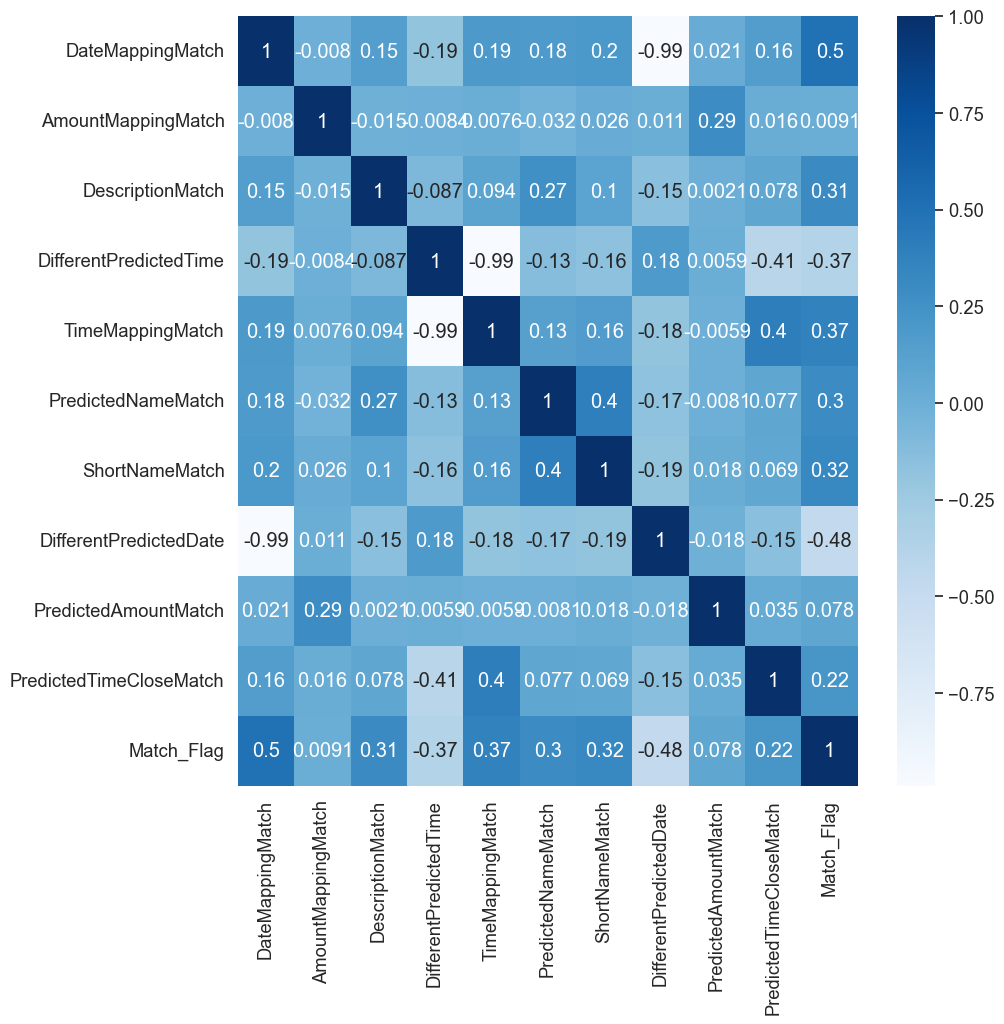

In [7]:
#correlation check
import matplotlib.pyplot as  plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.2)
plt.figure(figsize=(10,10))
corr=data_v1.corr()
sns.heatmap(corr, annot=True,cmap="Blues")

Multicollinearity Check

In [8]:
df_train=data.copy()
X = df_train.drop('Match_Flag',1)
y = df_train.Match_Flag

C:\Users\91948\AppData\Local\Temp\ipykernel_31232\4233801435.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_train.drop('Match_Flag',1)


In [9]:
from patsy import dmatrices, Treatment
y, X = dmatrices('Match_Flag ~  AmountMappingMatch+DescriptionMatch+\
                TimeMappingMatch+PredictedNameMatch+ShortNameMatch+PredictedAmountMatch+\
                PredictedTimeCloseMatch', df_train, return_type = 'dataframe')

In [10]:
###Check for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifdf=pd.DataFrame(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)).reset_index()
vifdf.columns=['Variable','VIF']
print(vifdf.sort_values(by=['VIF'],ascending=False))

                  Variable       VIF
4       PredictedNameMatch  1.267206
3         TimeMappingMatch  1.224733
0                Intercept  1.208678
5           ShortNameMatch  1.205756
7  PredictedTimeCloseMatch  1.197003
1       AmountMappingMatch  1.092535
6     PredictedAmountMatch  1.091727
2         DescriptionMatch  1.082061


From Correlation testing and Multicollinearity testing testing we conclude that DifferentPredictedDate, DifferentPredictedTime, DateMappingMatch are not important or are causing multicollinearity 

In [11]:
#Drop the three variables 
data_v1 = data_v1.drop(columns=['DifferentPredictedDate', 'DifferentPredictedTime','DateMappingMatch'])

In [12]:
data_v1.head()

,AmountMappingMatch,DescriptionMatch,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,PredictedAmountMatch,PredictedTimeCloseMatch,Match_Flag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Balancing the DataSet and Train-Test-Split

In [13]:
X = data_v1.drop(['Match_Flag'],axis=1)
y = data_v1['Match_Flag']
print(X.shape,y.shape)

(12034, 7) (12034,)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [15]:
print(X_train.shape, X_test.shape)

(8423, 7) (3611, 7)


In [16]:
#Oversampling the data
import imblearn
from imblearn.over_sampling import SMOTE

Sample= SMOTE()
X_train, y_train = Sample.fit_resample(X_train, y_train)

In [17]:
print(X_train.shape,y_train.shape)

(15646, 7) (15646,)


In [ ]:
'DateMappingMatch',
 'AmountMappingMatch',
 'DescriptionMatch',
 'DifferentPredictedTime',
 'TimeMappingMatch',
 'PredictedNameMatch',
 'ShortNameMatch',
 'DifferentPredictedDate',
 'PredictedAmountMatch',
 'PredictedTimeCloseMatch'

In [21]:
data_v1.columns

Index(['AmountMappingMatch', 'DescriptionMatch', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'PredictedAmountMatch',
       'PredictedTimeCloseMatch', 'Match_Flag'],
      dtype='object')

# EDA with "woe" and "event rate"

In [26]:
from optbinning import OptimalBinning

Vairiation for:  AmountMappingMatch
Graph for WOE


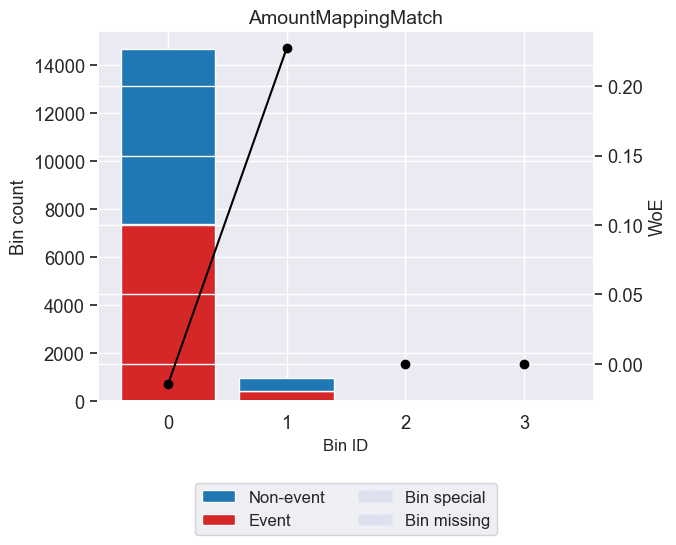

Graph for Event Rate


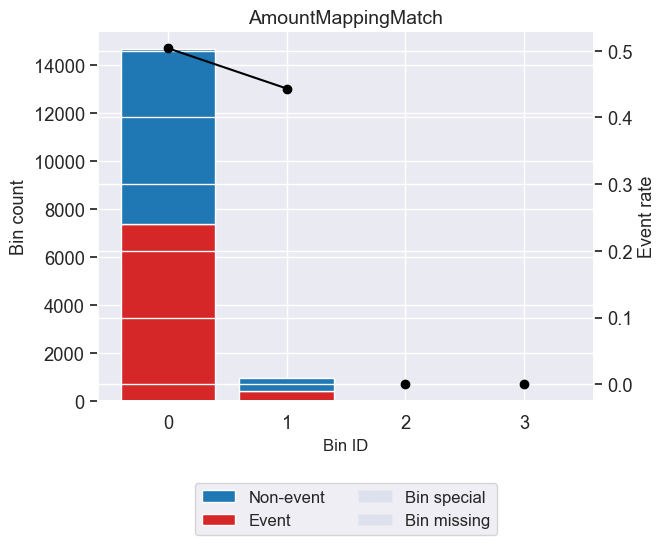

In [48]:
for i in ['AmountMappingMatch']:
    optb = OptimalBinning(name=i, dtype="numerical", solver="cp")
    optb.fit(X_train[i], y_train)
    binning_table = optb.binning_table
    binning_table.build()
    print("Vairiation for: ",i)
    print("Graph for WOE")
    binning_table.plot(metric="woe")
    print("Graph for Event Rate")
    binning_table.plot(metric="event_rate")

Vairiation for:  DescriptionMatch
Graph for WOE


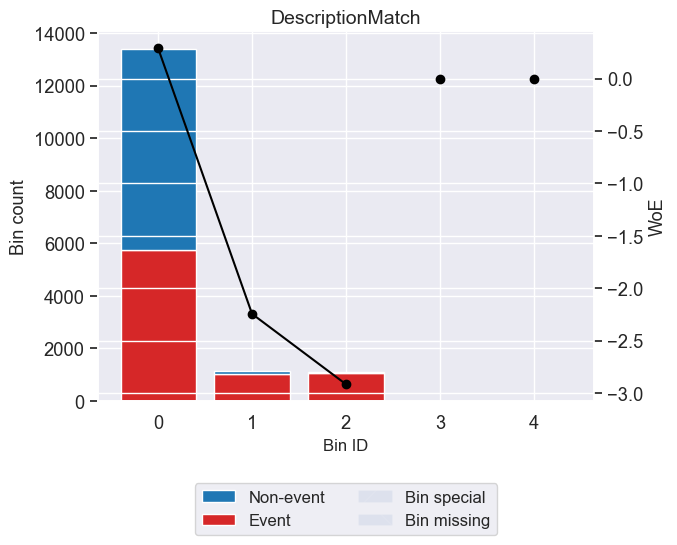

Graph for Event Rate


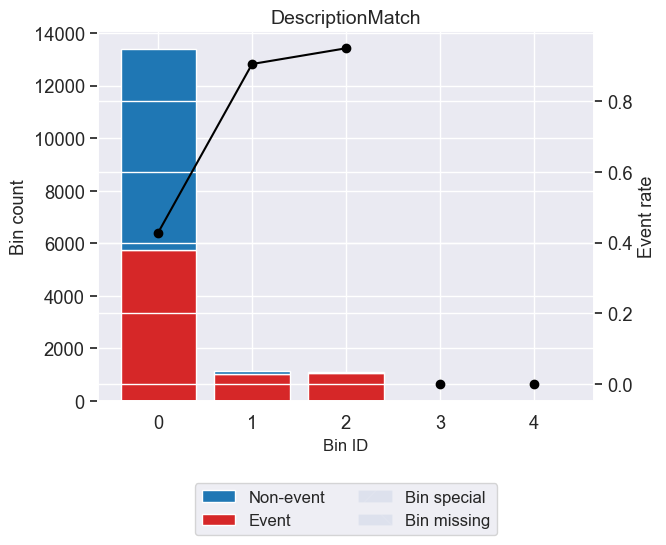

In [38]:
for i in ['DescriptionMatch']:
    optb = OptimalBinning(name=i, dtype="numerical", solver="cp")
    optb.fit(X_train[i], y_train)
    binning_table = optb.binning_table
    binning_table.build()
    print("Vairiation for: ",i)
    print("Graph for WOE")
    binning_table.plot(metric="woe")
    print("Graph for Event Rate")
    binning_table.plot(metric="event_rate")

Vairiation for:  TimeMappingMatch
Graph for WOE


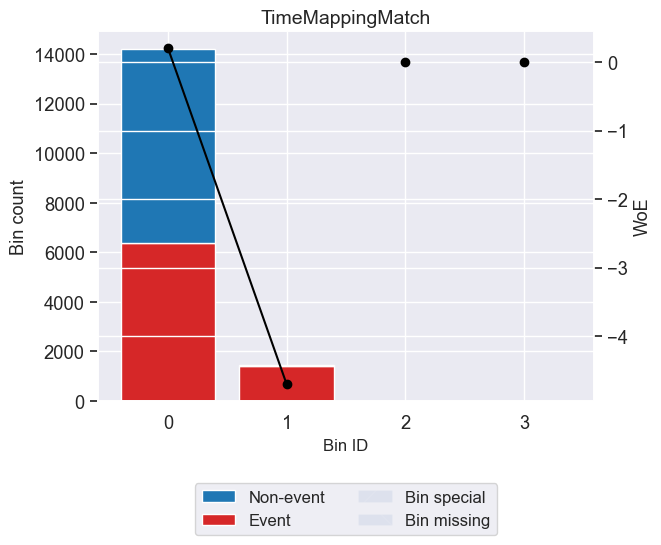

Graph for Event Rate


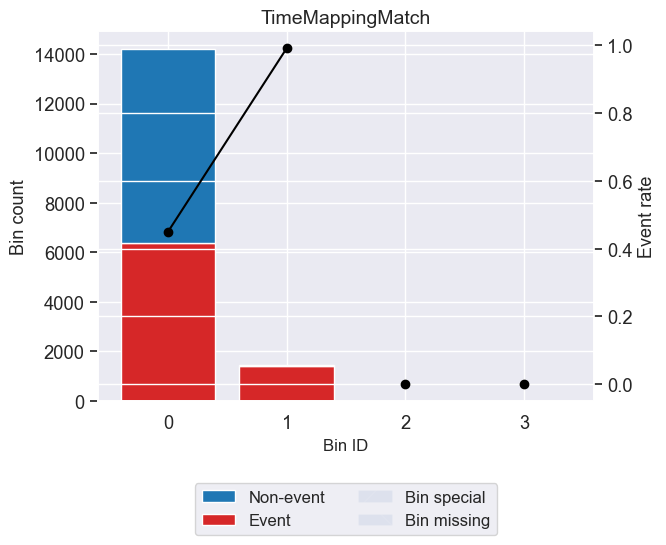

In [39]:
for i in ['TimeMappingMatch']:
    optb = OptimalBinning(name=i, dtype="numerical", solver="cp")
    optb.fit(X_train[i], y_train)
    binning_table = optb.binning_table
    binning_table.build()
    print("Vairiation for: ",i)
    print("Graph for WOE")
    binning_table.plot(metric="woe")
    print("Graph for Event Rate")
    binning_table.plot(metric="event_rate")

Vairiation for:  PredictedNameMatch
Graph for WOE


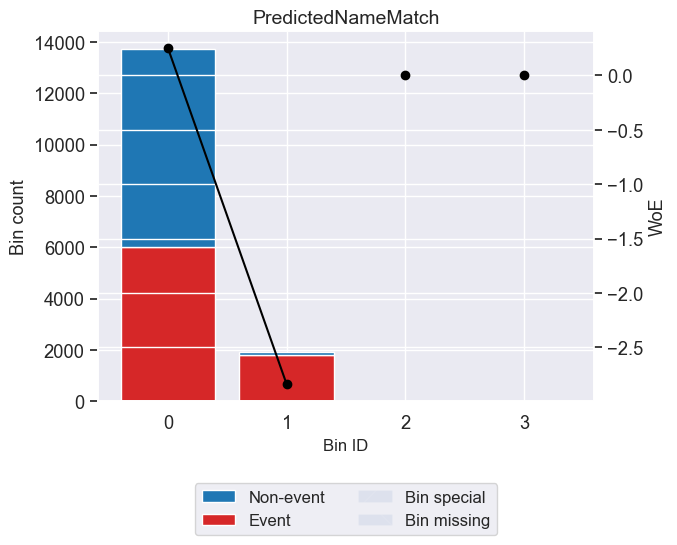

Graph for Event Rate


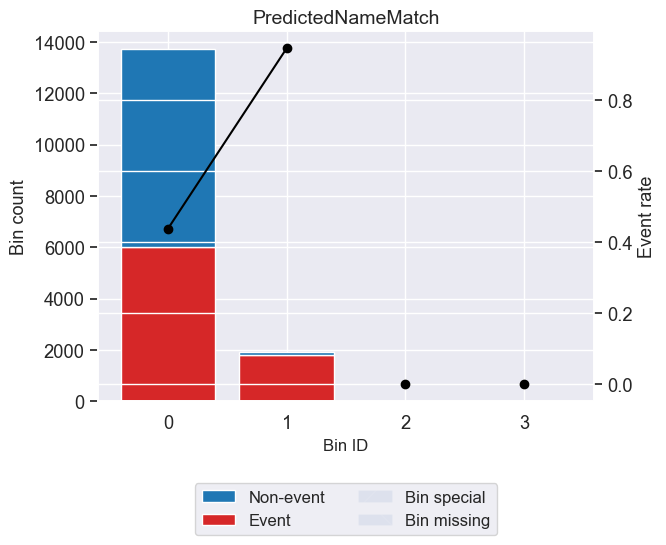

In [40]:
for i in ['PredictedNameMatch']:
    optb = OptimalBinning(name=i, dtype="numerical", solver="cp")
    optb.fit(X_train[i], y_train)
    binning_table = optb.binning_table
    binning_table.build()
    print("Vairiation for: ",i)
    print("Graph for WOE")
    binning_table.plot(metric="woe")
    print("Graph for Event Rate")
    binning_table.plot(metric="event_rate")

Vairiation for:  ShortNameMatch
Graph for WOE


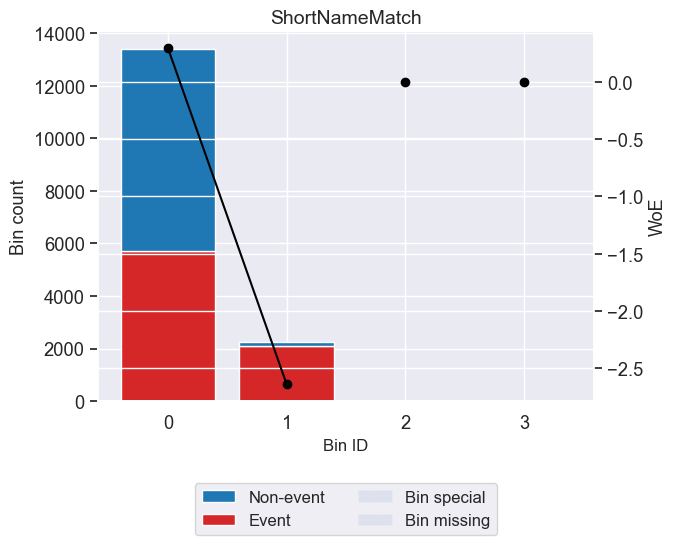

Graph for Event Rate


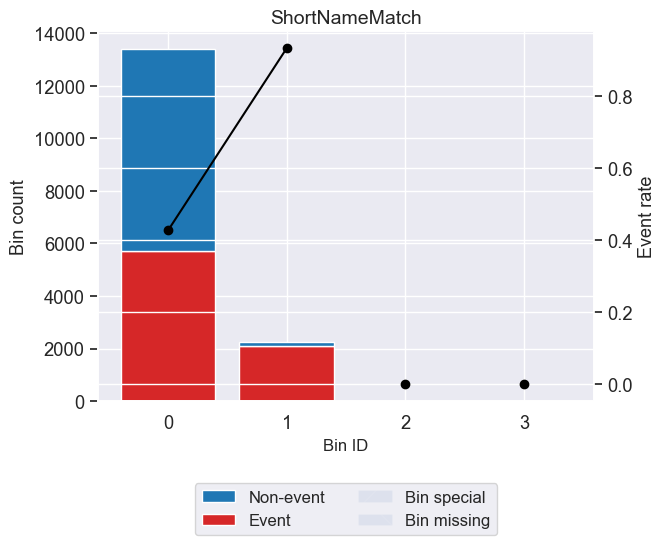

In [41]:
for i in ['ShortNameMatch']:
    optb = OptimalBinning(name=i, dtype="numerical", solver="cp")
    optb.fit(X_train[i], y_train)
    binning_table = optb.binning_table
    binning_table.build()
    print("Vairiation for: ",i)
    print("Graph for WOE")
    binning_table.plot(metric="woe")
    print("Graph for Event Rate")
    binning_table.plot(metric="event_rate")

Vairiation for:  PredictedTimeCloseMatch
Graph for WOE


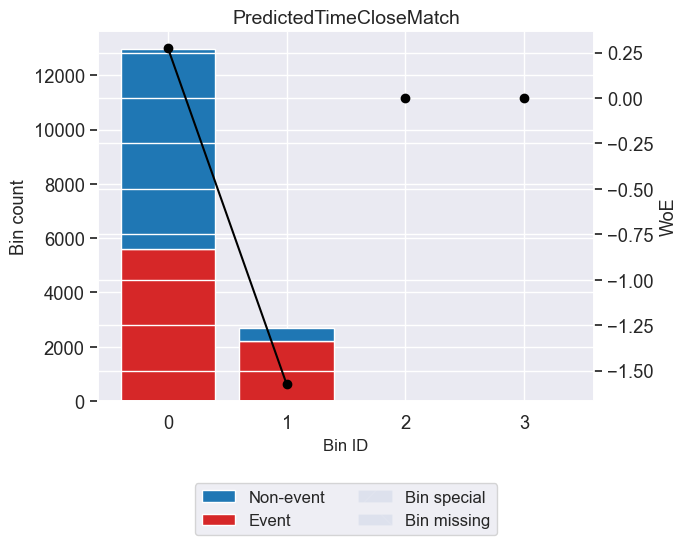

Graph for Event Rate


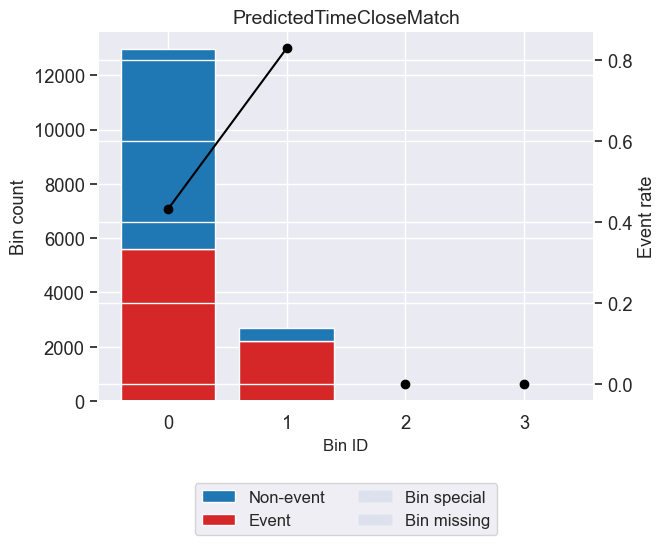

In [43]:
for i in ['PredictedTimeCloseMatch']:
    optb = OptimalBinning(name=i, dtype="numerical", solver="cp")
    optb.fit(X_train[i], y_train)
    binning_table = optb.binning_table
    binning_table.build()
    print("Vairiation for: ",i)
    print("Graph for WOE")
    binning_table.plot(metric="woe")
    print("Graph for Event Rate")
    binning_table.plot(metric="event_rate")

There is general monotonicity in all remaining features. We will model these features and see how they impact pur model

# Modelling and Evaluation

In [18]:
from sklearn.metrics import classification_report , confusion_matrix

Logistic Regression

{'C': 0.08105263157894736, 'solver': 'newton-cg'}
ROC Value:  0.8051934040079909
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3354
           1       0.31      0.66      0.42       257

    accuracy                           0.87      3611
   macro avg       0.64      0.77      0.67      3611
weighted avg       0.92      0.87      0.89      3611



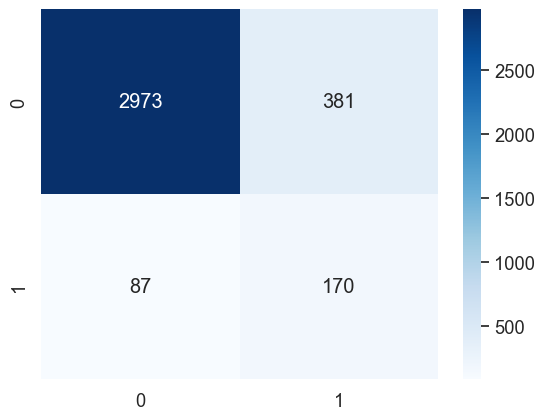

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

logit = LogisticRegression(random_state=42)

log_params =  [{'C': np.linspace(0.01,0.1,20), 'solver': ['newton-cg', 'lbfgs','sag']}]
log_clf = GridSearchCV(logit, log_params, cv = 10, scoring='roc_auc')
log_clf.fit(X_train, y_train)

predicted = log_clf.predict(X_test)
proba = log_clf.predict_proba(X_test)[:,1]

print(log_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='',cmap="Blues");

Random Forest

{'max_depth': 7, 'max_features': 4, 'n_estimators': 99}
ROC Value:  0.8104568794099153 Best Score
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3354
           1       0.34      0.68      0.45       257

    accuracy                           0.88      3611
   macro avg       0.66      0.79      0.69      3611
weighted avg       0.93      0.88      0.90      3611



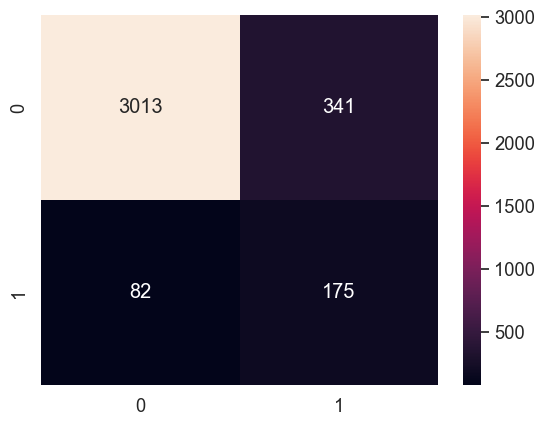

In [99]:
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier()

rfm_params =  [{'max_depth': list(range(5,20)),'n_estimators':np.arange(10,100),'max_features': list(range(2,20))}]

rfm_clf = GridSearchCV(rfm, rfm_params, cv = 10, scoring='roc_auc')
rfm_clf.fit(X_train, y_train)

predicted = rfm_clf.predict(X_test)
proba = rfm_clf.predict_proba(X_test)[:,1]

print(rfm_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');

Gradient Boosting

{'max_depth': 4, 'min_samples_split': 20, 'n_estimators': 90}
ROC Value:  0.8104568794099153
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3354
           1       0.33      0.67      0.44       257

    accuracy                           0.88      3611
   macro avg       0.65      0.78      0.69      3611
weighted avg       0.93      0.88      0.90      3611



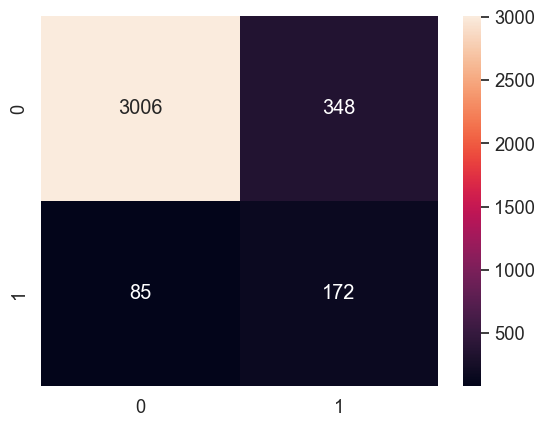

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=42)

gbm_params =  [{'max_depth': list(range(2,20,2)),'n_estimators':list(range(10,100,10)),'min_samples_split': list(range(2,50,2))}]

gbm_clf = GridSearchCV(gbm, gbm_params, cv = 10, scoring='roc_auc')
gbm_clf.fit(X_train, y_train)

predicted = gbm_clf.predict(X_test)
proba = rfm_clf.predict_proba(X_test)[:,1]

print(gbm_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');

KNN model

{'n_neighbors': 18, 'weights': 'distance'}
ROC Value:  0.8083779400402331
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3354
           1       0.65      0.31      0.42       257

    accuracy                           0.94      3611
   macro avg       0.80      0.65      0.69      3611
weighted avg       0.93      0.94      0.93      3611



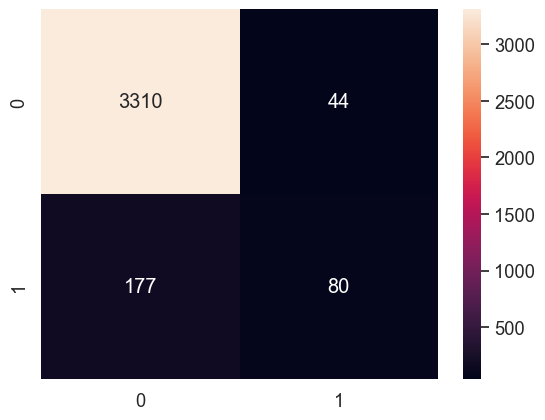

In [32]:
from sklearn.neighbors import KNeighborsClassifier

KnnClass = KNeighborsClassifier()

knn_params =  [{'n_neighbors': range(1,20), 'weights': ['uniform','distance']}]
knn_clf = GridSearchCV(KnnClass, knn_params, cv = 10, scoring='roc_auc')
knn_clf.fit(X_train, y_train)

predicted = knn_clf.predict(X_test)
proba = knn_clf.predict_proba(X_test)[:,1]

print(knn_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');

SVM model

{'C': 1.0}
ROC Value:  0.8037792147827438
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3354
           1       0.45      0.61      0.52       257

    accuracy                           0.92      3611
   macro avg       0.71      0.78      0.74      3611
weighted avg       0.93      0.92      0.92      3611



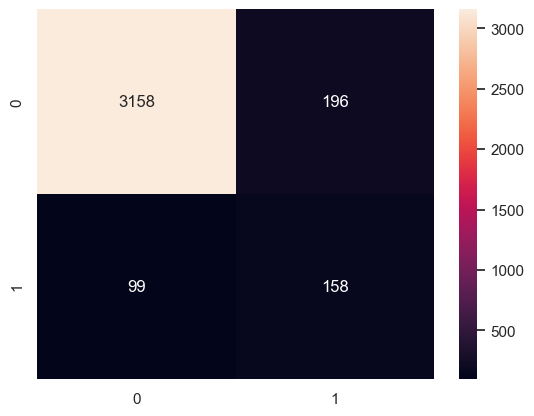

In [63]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

svc = svm.SVC(probability=True,kernel='linear',random_state=42)

svc_params =  [{'C': np.linspace(0.1,1,5)}]
svc_clf = GridSearchCV(svc, svc_params, cv = 10, scoring='roc_auc')
svc_clf.fit(X_train, y_train)

predicted = svc_clf.predict(X_test)
proba = svc_clf.predict_proba(X_test)[:,1]

print(svc_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');

Adaptive Boosting

{'learning_rate': 1, 'n_estimators': 75}
ROC Value:  0.8058912176412856
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3354
           1       0.48      0.61      0.54       257

    accuracy                           0.93      3611
   macro avg       0.73      0.78      0.75      3611
weighted avg       0.93      0.93      0.93      3611



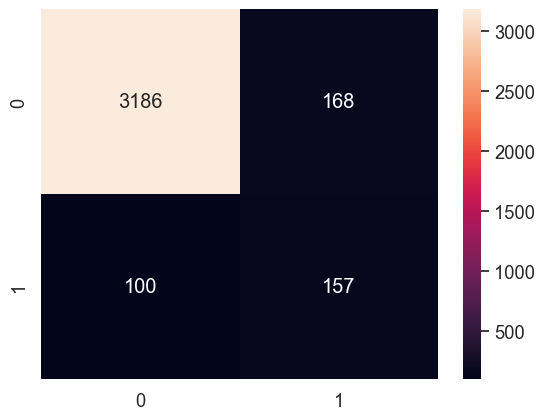

In [125]:
from sklearn.ensemble import AdaBoostClassifier

ABClass = AdaBoostClassifier(algorithm='SAMME')

ABClass_params =  [{'n_estimators': [25,50,75],'learning_rate':[0.25,0.5,0.75,1]}]

ABClass_clf = GridSearchCV(ABClass, ABClass_params, cv = 10, scoring='roc_auc')
ABClass_clf.fit(X_train, y_train)

predicted = ABClass_clf.predict(X_test)
proba = ABClass_clf.predict_proba(X_test)[:,1]

print(ABClass_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');

Artificial Neural Network model

1565/1565 [==============================] - 2s 1ms/step - loss: 0.4595 - accuracy: 0.7943
Train:
0.45954427123069763
0.7942605018615723
362/362 [==============================] - 0s 729us/step - loss: 0.4779 - accuracy: 0.8726
Test:
0.47792938351631165
0.8726114630699158
ROC Value:  0.7814538190069816


Text(0.5, 16.049999999999997, 'Predicted label')

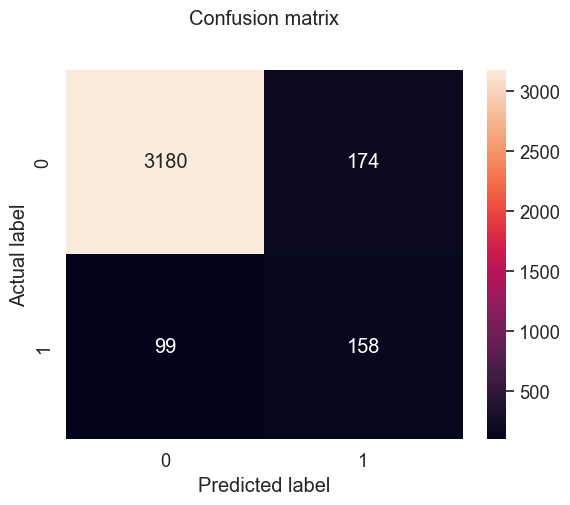

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
Ann_class = Sequential()

Ann_class.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 7))
Ann_class.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
Ann_class.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


Ann_class.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
Ann_class.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

sc, accuracy = Ann_class.evaluate(X_train, y_train,
                            batch_size=10)

print("Train:")
print(sc)
print(accuracy)

y_pred = Ann_class.predict(X_test)
y_pred = (y_pred > 0.5)


sc, accuracy = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print("Test:")
print(sc)
print(accuracy)


con_matrix= confusion_matrix(y_test, y_pred)

print("ROC Value: ", roc_auc_score(y_test,y_pred))

sns.heatmap(pd.DataFrame(con_matrix), annot=True,  fmt='')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Comparing Models performance

ROC Values:

Logistic Regression: 0.80544167020504,
Ramdom Forest      : 0.8103408671683036,
SVM                : 0.8037792147827438,
Adaboost           : 0.8058912176412856,
KNN                : 0.8081824594131173,
ANN                : 0.784116299951971

For the above results we can conclude that Random Forest is the best algorithm

{'max_depth': 7, 'max_features': 4, 'n_estimators': 99}
ROC Value:  0.8103408671683036
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3354
           1       0.34      0.68      0.45       257

    accuracy                           0.88      3611
   macro avg       0.66      0.79      0.69      3611
weighted avg       0.93      0.88      0.90      3611



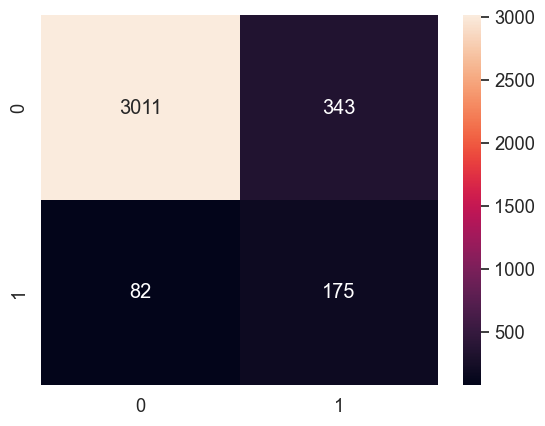

In [40]:
##Fitting the RFM again with narrowing down to best params for faster processing
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier()

rfm_params =  [{'max_depth': list(range(7,8)),'n_estimators':np.arange(99,100),'max_features': list(range(4,5))}]

rfm_clf = GridSearchCV(rfm, rfm_params, cv = 10, scoring='roc_auc')
rfm_clf.fit(X_train, y_train)

predicted = rfm_clf.predict(X_test)
proba = rfm_clf.predict_proba(X_test)[:,1]

print(rfm_clf.best_params_)
print("ROC Value: ", roc_auc_score(y_test,proba))

print(classification_report(y_test,predicted))
sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');

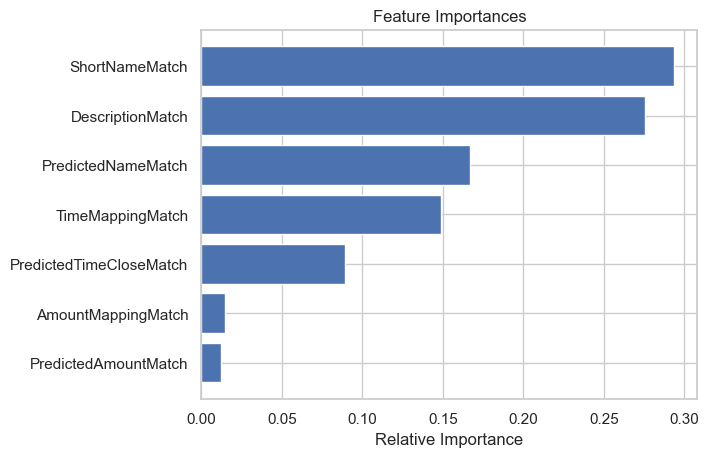

In [61]:
features = X_train.columns.tolist()
importances = rfm_clf.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [64]:
#Saving the model
import pickle
pickle.dump(rfm_clf, open('random_forest_model.pkl', 'wb'))

#load model
#rfm_clf = pickle.load(open('random_forest_model.pkl', 'rb'))